# Продвинутые методы глубокого обучения. Домашнее задание. Соревнование на Kaggle (HW)

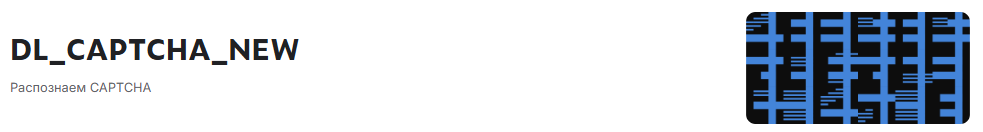

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os

## Загрузка данных

In [2]:
# Путь к данным относительно текущей директории ноутбука
data_path = os.path.join(os.getcwd(), 'data')

# Загрузка данных
images = np.load(os.path.join(data_path, 'images.npy'))
labels = np.load(os.path.join(data_path, 'labels.npy'))
images_sub = np.load(os.path.join(data_path, 'images_sub.npy'))

# Проверка размеров массивов
print(f"Размер массива images: {images.shape}")
print(f"Размер массива labels: {labels.shape}")
print(f"Размер массива images_sub: {images.shape}")

Размер массива images: (20000, 48, 48, 3)
Размер массива labels: (20000,)
Размер массива images_sub: (20000, 48, 48, 3)


## Визуализация данных

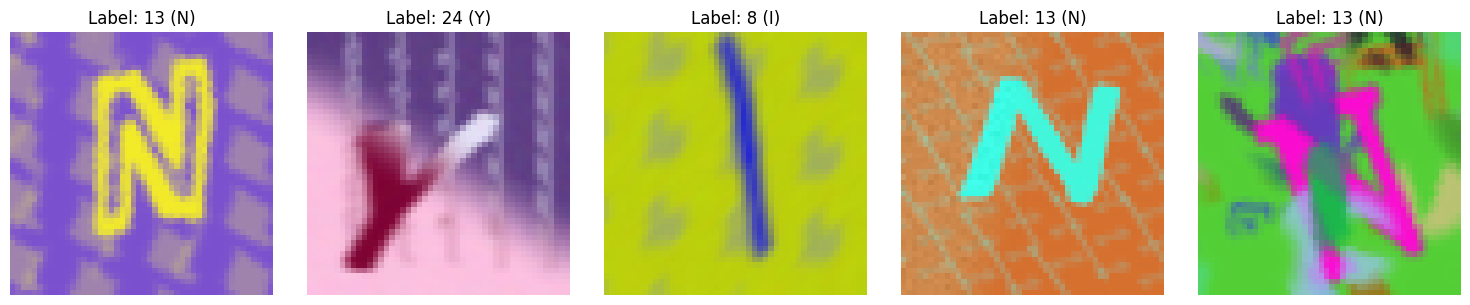

In [3]:
# Отображение примеров изображений
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]} ({chr(65+labels[i])})")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Предобработка данных

In [4]:
# Нормализация изображений
images = images / 255.0
images_sub = images_sub / 255.0

# Преобразование меток в one-hot encoding
labels_one_hot = to_categorical(labels, num_classes=26)

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    images, labels_one_hot, test_size=0.2, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape}, {y_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}, {y_val.shape}")

Размер обучающей выборки: (16000, 48, 48, 3), (16000, 26)
Размер валидационной выборки: (4000, 48, 48, 3), (4000, 26)


## Создание архитектуры модели

In [5]:
# Расширение данных (Data Augmentation)
datagen = ImageDataGenerator(
    rotation_range=10, # Случайный поворот в диапазоне 10 градусов
    width_shift_range=0.1, # Случайный сдвиг по ширине в диапазоне 10%
    height_shift_range=0.1, # Случайный сдвиг по высоте в диапазоне 10%
    zoom_range=0.1, # Случайное масштабирование в диапазоне 10%
    horizontal_flip=False, # Без горизонтального отражения (буквы не нужно отражать)
    fill_mode='nearest' # Заполнение пикселей за пределами границ
)

# Функция для создания блока ResNet
def residual_block(x, filters, kernel_size=3, strides=1, with_conv_shortcut=False):
    shortcut = x
    
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    if with_conv_shortcut:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

# Создание модели с residual connections
def create_improved_model():
    inputs = Input(shape=(48, 48, 3))
    
    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)
    
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.25)(x)
    
    x = residual_block(x, 128, with_conv_shortcut=True)
    x = residual_block(x, 128)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.25)(x)
    
    x = residual_block(x, 256, with_conv_shortcut=True)
    x = residual_block(x, 256)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(26, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Создание модели
model = create_improved_model()

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Вывод структуры модели
model.summary()

# Колбэки для обучения
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 48, 48, 64)   0           ['batch_normalization[0][0]']

## Обучение и мониторинг

Начало обучения модели
Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 3.5390 - accuracy: 0.0479   
Epoch 1: val_accuracy improved from -inf to 0.03200, saving model to best_model.h5
250/250 [==============================] - 14s 48ms/step - loss: 3.5390 - accuracy: 0.0479 - val_loss: 3.2971 - val_accuracy: 0.0320 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 3.1876 - accuracy: 0.1168 
Epoch 2: val_accuracy improved from 0.03200 to 0.20850, saving model to best_model.h5
250/250 [==============================] - 12s 46ms/step - loss: 3.1876 - accuracy: 0.1168 - val_loss: 2.7639 - val_accuracy: 0.2085 - lr: 0.0010
Epoch 3/100
249/250 [============================>.] - ETA: 0s - loss: 2.0566 - accuracy: 0.3924 
Epoch 3: val_accuracy improved from 0.20850 to 0.51750, saving model to best_model.h5
250/250 [==============================] - 12s 46ms/step - loss: 2.0543 - accuracy: 0.3931 - val_loss: 1.5023 - val_accuracy: 0.5175 -

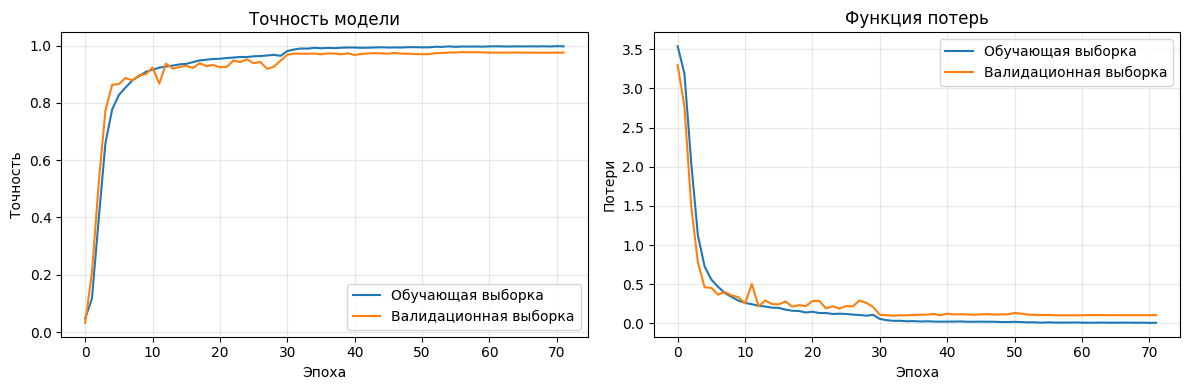

In [6]:
# Обучение модели
print("Начало обучения модели")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Загрузка лучшей модели
model.load_weights('best_model.h5')

# Визуализация процесса обучения
plt.figure(figsize=(12, 4))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Валидационная выборка')
plt.title('Точность модели')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True, alpha=0.3)

# График функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Валидационная выборка')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Результаты и предсказания

In [7]:
# Оценка модели на валидационной выборке
print("Оценка модели на валидационной выборке")
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Точность на валидационной выборке: {val_accuracy:.4f}")

# Создание предсказаний для тестовых данных
print("Создание предсказаний для тестовых данных")
predictions = model.predict(images_sub)
predicted_classes = np.argmax(predictions, axis=1)





Оценка модели на валидационной выборке
125/125 [==============================] - 1s 7ms/step - loss: 0.1036 - accuracy: 0.9775
Точность на валидационной выборке: 0.9775
Создание предсказаний для тестовых данных
1563/1563 [==============================] - 10s 6ms/step


## Сохранение результатов

In [8]:
# Создание файла
submission = pd.DataFrame({
    'Id': range(len(predicted_classes)),
    'Category': predicted_classes
})

# Сохранение файла
submission_path = os.path.join(data_path, 'submission.csv')
submission.to_csv(submission_path, index=False)
print(f"Файл создан: {submission_path}")

Файл создан: C:\Users\bulah\MIFI\Продвинутые методы глубокого обучения\HW_1\data\submission.csv


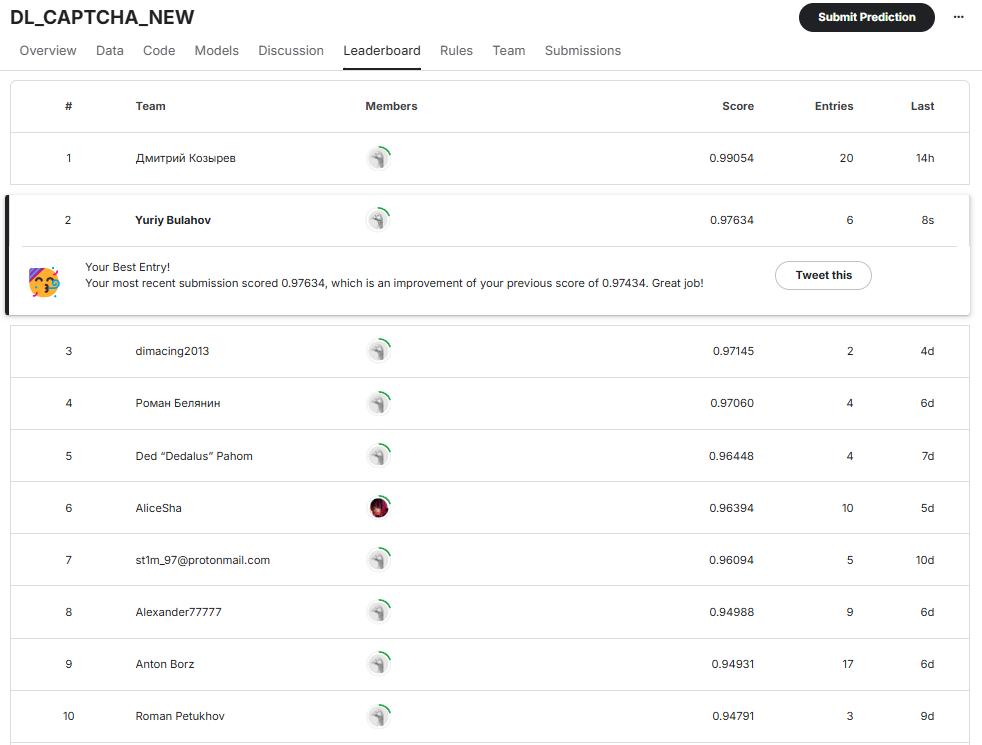